In [8]:
import torch as ch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import tqdm
from tqdm.contrib.concurrent import thread_map
from functools import partial

import numpy as np
import pandas as pd
from scipy.special import softmax

import seaborn as sns
sns.set_theme()

In [2]:
class LogitMetrics:
    def __init__(self, logits, labels):
        self.logits = logits
        self.labels = labels
        
    def margins(self):
        def compute(idx, logits, labels, margins):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
            indices = np.arange(labels.shape[0]) # Create an array of incremental indices for future indexing

            correct = logits_idx[indices, labels] # Set the correct logits of each sample to be the ones indexed by the labels
            logits_idx[indices, labels] = -np.inf # Set the logit corresponding to the correct index to -inf
            top_incorrect = logits_idx.max(axis = -1) # Set the highest incorrect logit to be the max of the logits along the logits axis

            margins[idx] = correct - top_incorrect # The margin is difference between the correct and highest incorrect logit
            
            
        margins = np.zeros((self.logits.shape[0], self.logits.shape[1]))
        margins_partial = partial(compute,
                                  logits = self.logits,
                                  labels = self.labels,
                                  margins = margins)
        thread_map(margins_partial, np.arange(self.logits.shape[0]))
        
        return margins
    
    
    #TODO: Add another std implementation that computes std along the samples axis instead of the logits axis
    def std(self):
        def compute(idx, logits, std):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
    
            std[idx] = np.std(logits_idx, axis = -1) # Compute stdev along the logits axis
        
        
        std = np.zeros((self.logits.shape[0], self.logits.shape[1]))
        std_partial = partial(compute,
                              logits = self.logits,
                              std = std)
        thread_map(std_partial, np.arange(self.logits.shape[0]))
        
        return std
    
    
    #ECE = Weighted Average(|Accuracy_m - Confidence_m|) ---- Weighted by the relative proportion of each bin (m is the bin index)
    def ece(self, n_bins = 10):
        def compute(idx, n_bins, logits, labels, ece):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
            probs = softmax(logits_idx, axis = 1) # Apply softmax to logits
            
            bin_edges = np.arange(start = 0, stop = 1 + 1/n_bins, step = 1/n_bins) # Set the bin edges 
            bin_lefts = bin_edges[:-1] 
            bin_rights = bin_edges[1:]

            conf = np.max(probs, axis = -1) # Confidences = maximum softmax probabilities
            preds = np.argmax(probs, axis = -1) # Predictions = indices of maximum softmax probabilities
            correct = (preds == labels) # Find correct predictions

            curr_ece = 0

            for bin_left, bin_right in zip(bin_lefts, bin_rights):
                inside = (conf > bin_left) * (conf <= bin_right) # Find confidences that fall inside the current bin
                weight = inside.astype(float).mean() # Weight = proportion of confidences inside the currrent bin
                if weight > 0:
                    acc_bin = correct[inside].astype(float).mean() # Bin Accuracy = mean of 1(y^ = y)
                    conf_bin = conf[inside].astype(float).mean() # Bin Confidence = mean of confidences inside
                    curr_ece += abs(acc_bin - conf_bin) * weight # ECE += |Bin Accuracy - Bin Conf.| * weight
            
            ece[idx] = curr_ece
            
            
        ece = np.zeros(self.logits.shape[0])
        ece_partial = partial(compute,
                              n_bins = n_bins,
                              logits = self.logits,
                              labels = self.labels,
                              ece = ece)
        thread_map(ece_partial, np.arange(self.logits.shape[0]))
        
        return ece

In [3]:
ds_val = CIFAR10(root = '/home/gridsan/groups/robustness/datasets/cifar',
                 download = False,
                 train = False,
                 transform = ToTensor())

val_labels = np.array(ds_val.targets)
val_logits = np.lib.format.open_memmap('/home/gridsan/ahazimeh/src/data-rv/results/result_1/val_logits.npy', mode = 'r')

In [ ]:
#Will take ~10-20mins to complete on 10 CPUs
TG = LogitMetrics(val_logits, val_labels)
ece = TG.ece(n_bins = 10)

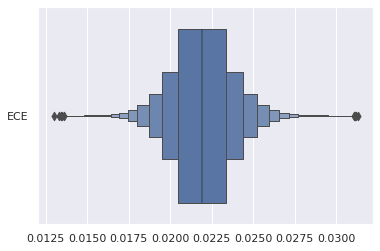

In [14]:
#ECE seems normally distributed
ece_df = pd.DataFrame({'ECE': ece})

_ = sns.boxenplot(data = ece_df, orient = "h", linewidth = 1)

In [15]:
ece_df.describe()

,ECE
count,310000.000000
mean,0.021937
std,0.002119
min,0.012982
25%,0.020498
50%,0.021919
75%,0.023359
max,0.031312
